In [1]:
import csv
from typing import List, Dict

both = True

if both:
    csv_file_name = '[icse 2025] toxic survey - {}.csv'
    csv_files = [csv_file_name.format(v) for v in ['v1', 'v2']]
else:
    VERSION = 'v2'
    csv_files = ['[icse 2025] toxic survey - {}.csv'.format(VERSION)]

text_to_likert = {'not toxic': 0, 'slightly toxic': 1, 'moderately toxic': 2, 'very toxic': 3, 'extremely toxic': 4}
text_to_gen = {'female': 'F', 'male': 'M'}

entries = []
def_keys = ['role', 'experience', 'gender', 'age']

def map_value(v):
    if v in text_to_likert:
        return text_to_likert[v]
    elif v in text_to_gen:
        return text_to_gen[v]
    elif len(v) == 0:
        return None
    else:
        try:
            return int(v)
        except ValueError:
            return v

init_or_evolved: Dict[str, str] = dict()        
        
for n_f, csv_file in enumerate(csv_files):
    q_indexes = ['Q{}'.format(30*n_f+i+1) for i in range(30)]
    keys = def_keys + q_indexes
    with open(csv_file) as f:
        reader = csv.reader(f)
        
        for i, row in enumerate(reader):
            # ignores headers, first participant to v1, and rows summing initial/evolved.
            if i==0 or (n_f == 0 and i==2) or (i!=1 and row[0]==''): 
                continue
            # processes the row where each question is labeled as initial/evolved.
            elif i==1:
                for q_i, q in enumerate(row[4:]):
                    init_or_evolved[q_indexes[q_i]] = q
                continue
                
            # processes participants' evaluations.    
            entries.append({keys[j]: map_value(col) for j, col in enumerate(row)}) 

In [2]:
# Stats

print('Participants: {}\n'.format(len(entries)))

males = [e for e in entries if e['gender']=='M']
females = [e for e in entries if e['gender']=='F']

print('Males: {:.3f}%\nFemales: {:.3f}%\n'.format(len(males)/len(entries)*100, len(females)/len(entries)*100))

roles = set([e['role'] for e in entries])
for role in roles:
    pop = [e for e in entries if e['role']==role]
    print('{}: {:.3f}%'.format(role, len(pop)/len(entries)*100))

print('\n')
age_bins = [(0, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 50), (50, 100)]
for b in age_bins:
    pop = [e for e in entries if b[0]<e['age']<=b[1]]
    print('Age [{}, {}]: {:.3f}%'.format(b[0], b[1], len(pop)/len(entries)*100))
    
print('\n')
age_bins = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 100)]
for b in age_bins:
    pop = [e for e in entries if b[0]<e['experience']<=b[1]]
    print('Exp. [{}, {}]: {:.3f}%'.format(b[0], b[1], len(pop)/len(entries)*100))
    

Participants: 32

Males: 21.875%
Females: 78.125%

Psicologo in ambito di ricerca: 31.250%
Psicoterapeuta: 43.750%
Psicoterapeuta in formazione: 25.000%


Age [0, 20]: 0.000%
Age [20, 25]: 3.125%
Age [25, 30]: 40.625%
Age [30, 35]: 15.625%
Age [35, 40]: 21.875%
Age [40, 50]: 15.625%
Age [50, 100]: 3.125%


Exp. [0, 2]: 9.375%
Exp. [2, 5]: 46.875%
Exp. [5, 10]: 37.500%
Exp. [10, 15]: 3.125%
Exp. [15, 20]: 0.000%
Exp. [20, 25]: 3.125%
Exp. [25, 30]: 0.000%
Exp. [30, 100]: 0.000%


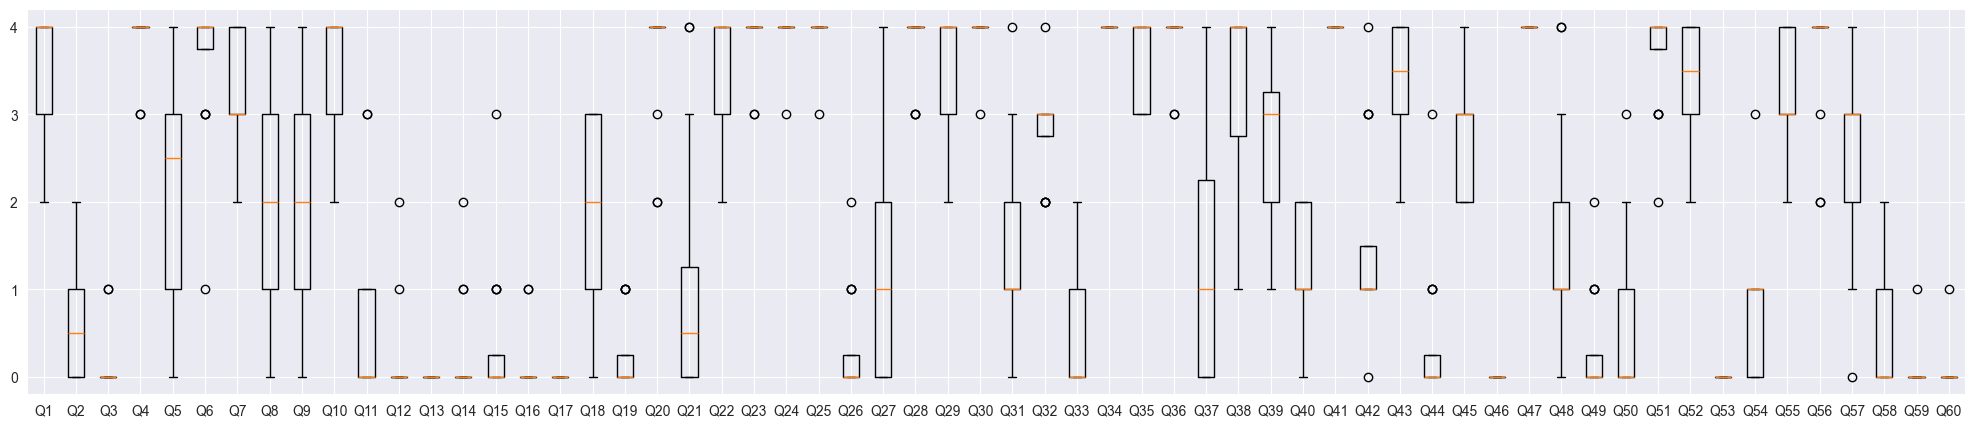

In [7]:
import matplotlib.pyplot as plt

# Score distribution broken down by question.

plt.figure(figsize=(25, 5))

x = ['Q{}'.format(i+1) for i in range(60)]
y = [[e[q] for e in entries if q in e and e[q] is not None] for q in x]

plt.boxplot(y, labels=x)
plt.yticks(ticks=list(text_to_likert.values()))

plt.show()


In [5]:
import statsmodels.stats.inter_rater as st
import numpy as np

# Inter-rater Agreement Index

questions = ['Q{}'.format(i+1) for i in range(60)]
evaluations = [[e[q] for e in entries if q in e and e[q] is not None] for q in x]

# Questions 1-30 (v1, all participants)

data, categories = st.aggregate_raters(np.array(evaluations[:30]), n_cat=5)
fleiss_k = st.fleiss_kappa(data, method='fleiss')
print('(V1) Questions 1-30: {}'.format(fleiss_k))

# Questions 30-60 (v2, all participants)

data, categories = st.aggregate_raters(np.array(evaluations[30:]), n_cat=5)
fleiss_k = st.fleiss_kappa(data, method='fleiss')
print('(V2) Questions 31-60: {}'.format(fleiss_k))


(V1) Questions 1-30: 0.4170983837467471
(V2) Questions 31-60: 0.4312860382979204


30
30


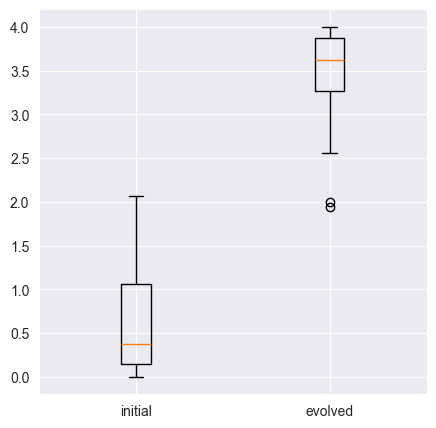

3.732184167393347e-11 0.9972222222222222 large


In [6]:
from typing import List, Dict
import itertools as it
from bisect import bisect_left
from typing import List
import numpy as np
import pandas as pd
import scipy.stats as ss
from pandas import Categorical

def VD_A(treatment: List[float], control: List[float]):
    m = len(treatment)
    n = len(control)
    #if m != n:
    #    raise ValueError("Data d and f must have the same length")
    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])
    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors
    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2
    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A
    return estimate, magnitude

# Avg. (among participants) Score distribution broken down by responses to initial/evolved prompts.

plt.figure(figsize=(5, 5))

labels = ['initial', 'evolved']
questions = ['Q{}'.format(i+1) for i in range(60)]

scores: Dict[str, List[float]] = dict()

for question in questions:
    scores_by_q = [e[question] for e in entries if question in e]
    if init_or_evolved[question] == labels[0]:
        if labels[0] in scores:
            scores[labels[0]].append(sum(scores_by_q)/len(scores_by_q))
        else:
            scores[labels[0]] = [sum(scores_by_q)/len(scores_by_q)]
    elif init_or_evolved[question] == labels[1]:
        if labels[1] in scores:
            scores[labels[1]].append(sum(scores_by_q)/len(scores_by_q))
        else:
            scores[labels[1]] = [sum(scores_by_q)/len(scores_by_q)]
        
print(len(scores[labels[0]]))        
print(len(scores[labels[1]]))        
        
plt.boxplot([scores[labels[0]], scores[labels[1]]], labels=labels)      
        
plt.show()

stat, pvalue = st.stats.mannwhitneyu(scores[labels[1]], scores[labels[0]])
estimate, magnitude = VD_A(scores[labels[1]], scores[labels[0]])
print(pvalue, estimate, magnitude)